In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import roc_curve, confusion_matrix, classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, cross_validate
#from sklearn.preprocessing import StandardScaler
#from sklearn.compose import ColumnTransformer
import warnings

## Preparando banco para modelagem

Foram indicadas para o python que variáveis são categóricas, além de separar o banco das covariáveis (X) e o banco da variável resposta (Y).

In [2]:
# Importando
banco = pd.read_excel("Dados\default of credit card clients.xls",header=1)

# Mudando o tipo das variáveis que são categóricas
banco.SEX = banco.SEX.astype("category")
banco.EDUCATION = banco.EDUCATION.astype("category")
banco.MARRIAGE = banco.MARRIAGE.astype("category")
banco.PAY_0 = banco.PAY_0.astype("category")
banco.PAY_2 = banco.PAY_2.astype("category")
banco.PAY_3 = banco.PAY_3.astype("category")
banco.PAY_4 = banco.PAY_4.astype("category")
banco.PAY_5 = banco.PAY_5.astype("category")
banco.PAY_6 = banco.PAY_6.astype("category")

# Separando a variável resposta
X=banco.loc[:, 'LIMIT_BAL':'PAY_AMT6']
y=banco["default payment next month"]

## Calculando correlação

Para a modelagem, precisamos analisar a correlação no banco de dados para evitar multicolinearidade. Geralmente normalização das variáveis resolve esse problema, porém foi observado que os modelos tiveram pior capacidade preditiva quando o banco era normalizado. Abaixo está o código para a normalização, apenas para demonstrar como esse processo é feito em python.

In [3]:
# padronização de variavies
#
#std = StandardScaler()
#
#numericas = X.loc[:,'BILL_AMT1':'PAY_AMT6']
#
#df = pd.DataFrame(std.fit_transform(numericas), columns = numericas.columns)
#
#correlacao = df.corr()
#
#correlacao.style.background_gradient(cmap='coolwarm')
#
#ct = ColumnTransformer([('scaler',StandardScaler(),numericas.columns)])
#X[numericas.columns] = ct.fit_transform(X)
#
#print(X)

Abaixo está a análise da correlação entre as covariáveis

In [4]:
correlacao = X.corr()
correlacao.style.background_gradient(cmap='coolwarm')

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
LIMIT_BAL,1.000000,0.144713,0.285430,0.278314,0.283236,0.293988,0.295562,0.290389,0.195236,0.178408,0.210167,0.203242,0.217202,0.219595
AGE,0.144713,1.000000,0.056239,0.054283,0.053710,0.051353,0.049345,0.047613,0.026147,0.021785,0.029247,0.021379,0.022850,0.019478
BILL_AMT1,0.285430,0.056239,1.000000,0.951484,0.892279,0.860272,0.829779,0.802650,0.140277,0.099355,0.156887,0.158303,0.167026,0.179341
BILL_AMT2,0.278314,0.054283,0.951484,1.000000,0.928326,0.892482,0.859778,0.831594,0.280365,0.100851,0.150718,0.147398,0.157957,0.174256
BILL_AMT3,0.283236,0.053710,0.892279,0.928326,1.000000,0.923969,0.883910,0.853320,0.244335,0.316936,0.130011,0.143405,0.179712,0.182326
BILL_AMT4,0.293988,0.051353,0.860272,0.892482,0.923969,1.000000,0.940134,0.900941,0.233012,0.207564,0.300023,0.130191,0.160433,0.177637
BILL_AMT5,0.295562,0.049345,0.829779,0.859778,0.883910,0.940134,1.000000,0.946197,0.217031,0.181246,0.252305,0.293118,0.141574,0.164184
BILL_AMT6,0.290389,0.047613,0.802650,0.831594,0.853320,0.900941,0.946197,1.000000,0.199965,0.172663,0.233770,0.250237,0.307729,0.115494
PAY_AMT1,0.195236,0.026147,0.140277,0.280365,0.244335,0.233012,0.217031,0.199965,1.000000,0.285576,0.252191,0.199558,0.148459,0.185735
PAY_AMT2,0.178408,0.021785,0.099355,0.100851,0.316936,0.207564,0.181246,0.172663,0.285576,1.000000,0.244770,0.180107,0.180908,0.157634


Removendo covariáveis com alta correlação

In [5]:
## Selecionando o triângulo superior da matriz de correlação
upper = correlacao.where(np.triu(np.ones(correlacao.shape), k=1).astype(bool))

In [6]:
## Encontrando as colunas com correlação maior do que 0.6

to_drop = [column for column in upper.columns if any(upper[column] > 0.60)]

print(to_drop)

['BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']


In [7]:
## Banco sem as variáveis altamente correlacionadas

X = X.drop(X[to_drop], axis=1)

In [8]:
## Problema de correlação continua não resolvido

teste = X.corr()
teste.style.background_gradient(cmap='coolwarm')

,LIMIT_BAL,AGE,BILL_AMT1,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
LIMIT_BAL,1.000000,0.144713,0.285430,0.195236,0.178408,0.210167,0.203242,0.217202,0.219595
AGE,0.144713,1.000000,0.056239,0.026147,0.021785,0.029247,0.021379,0.022850,0.019478
BILL_AMT1,0.285430,0.056239,1.000000,0.140277,0.099355,0.156887,0.158303,0.167026,0.179341
PAY_AMT1,0.195236,0.026147,0.140277,1.000000,0.285576,0.252191,0.199558,0.148459,0.185735
PAY_AMT2,0.178408,0.021785,0.099355,0.285576,1.000000,0.244770,0.180107,0.180908,0.157634
PAY_AMT3,0.210167,0.029247,0.156887,0.252191,0.244770,1.000000,0.216325,0.159214,0.162740
PAY_AMT4,0.203242,0.021379,0.158303,0.199558,0.180107,0.216325,1.000000,0.151830,0.157834
PAY_AMT5,0.217202,0.022850,0.167026,0.148459,0.180908,0.159214,0.151830,1.000000,0.154896
PAY_AMT6,0.219595,0.019478,0.179341,0.185735,0.157634,0.162740,0.157834,0.154896,1.000000


Dividindo banco de treino e verificação

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=37)

Montando função de prototipagem:

O scikit learn permite uma implementação simplificada dos modelos, além de apresentar uma gama diversificada de modelos para diversas situações, apesar de não ter um foco muito estatístico (testes relacionados a parametrização do modelo, tabela anova não estão presentes). Abaixo temos um exemplo de como a montagem do modelo é bastante simplificada com um uso de uma única função que treina e avalia precisão

In [10]:
resultados = []

def prototipo(modelo,xtreino,ytreino,xteste,yteste):
    global resultados

    modelo.fit(xtreino,ytreino)

    y_test_pred = modelo.predict(xteste)
    #matriz de confusão
    print(confusion_matrix(yteste, y_test_pred))
    #estatísticas gerais do modelo
    print(classification_report(yteste, y_test_pred))
    #curva ROC
    plt.rcParams["figure.figsize"] = (8,5)
    fpr, tpr, _ = roc_curve(yteste, y_test_pred)
    fig, ax = plt.subplots()
    ax.plot(fpr,tpr)
    ax.set(xlabel='False Positive Rate',ylabel='True Positive Rate')
    plt.show()

    cv = cross_validate(modelo,pd.concat([xtreino,xteste]),pd.concat([ytreino,yteste]), cv= 10, scoring = ('recall','precision','accuracy'))
    
    resultados.append(cv)

    print("\nA acuracia média com dez dobras é de",round(cv['test_accuracy'].mean()*100,2),"%", 'com erro padrão de ', np.std((cv['test_accuracy']*100)).round(2),"%","\n")
    print("\nA precisão média com dez dobras é de",round(cv['test_precision'].mean()*100,2),"%", 'com erro padrão de ', np.std((cv['test_precision']*100)).round(2),"%","\n")
    print("\nA sensibilidade média com dez dobras é de",round(cv['test_recall'].mean()*100,2),"%", 'com erro padrão de ', np.std((cv['test_recall']*100)).round(2),"%","\n")



# Modelos

Nesta seção temos os modelos e alguns comentários ligados a aplicação deles

# Regressão Logística

Falhou em convergir, o modelo resultante não tem capacidade preditiva

[[6997    0]
 [2003    0]]
              precision    recall  f1-score   support

           0       0.78      1.00      0.87      6997
           1       0.00      0.00      0.00      2003

    accuracy                           0.78      9000
   macro avg       0.39      0.50      0.44      9000
weighted avg       0.60      0.78      0.68      9000



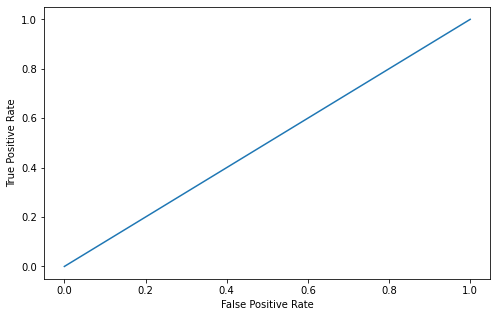


A acuracia média com dez dobras é de 77.88 % com erro padrão de  0.02 % 


A precisão média com dez dobras é de 0.0 % com erro padrão de  0.0 % 


A sensibilidade média com dez dobras é de 0.0 % com erro padrão de  0.0 % 



In [11]:
lr = LogisticRegression(max_iter=1000)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    prototipo(lr,X_train,y_train,X_test,y_test)

# Regressão Logística com SGD

Também não convergiu, porém com o algoritmo de SGD o modelo não coloca todas as respostas na mesma categoria. A documentação do scikit learn indica uma preferencia a esse método com bancos grandes por ser mais otimizado.


[[1994 5003]
 [ 571 1432]]
              precision    recall  f1-score   support

           0       0.78      0.28      0.42      6997
           1       0.22      0.71      0.34      2003

    accuracy                           0.38      9000
   macro avg       0.50      0.50      0.38      9000
weighted avg       0.65      0.38      0.40      9000



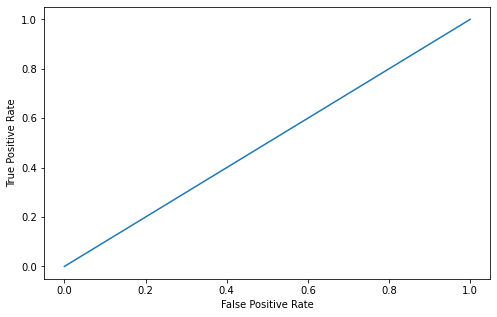


A acuracia média com dez dobras é de 65.88 % com erro padrão de  17.29 % 


A precisão média com dez dobras é de 14.38 % com erro padrão de  16.29 % 


A sensibilidade média com dez dobras é de 23.75 % com erro padrão de  33.05 % 



In [12]:
lr_sgd = SGDClassifier(loss='log')
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    prototipo(lr_sgd,X_train,y_train,X_test,y_test)

# Support Vector Machine RBF

Falhou em convergir também, mesmo comportamento observado na primeira implementação da regressão logística

[[6997    0]
 [2003    0]]
              precision    recall  f1-score   support

           0       0.78      1.00      0.87      6997
           1       0.00      0.00      0.00      2003

    accuracy                           0.78      9000
   macro avg       0.39      0.50      0.44      9000
weighted avg       0.60      0.78      0.68      9000



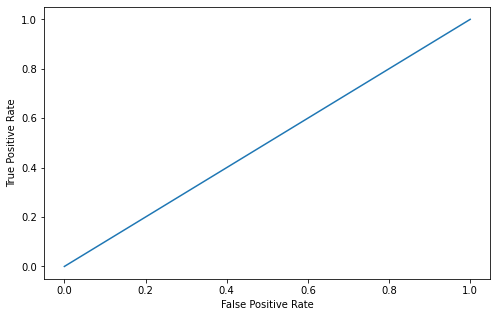


A acuracia média com dez dobras é de 68.3 % com erro padrão de  13.11 % 


A precisão média com dez dobras é de 11.21 % com erro padrão de  12.23 % 


A sensibilidade média com dez dobras é de 21.26 % com erro padrão de  27.06 % 



In [13]:
svc = SGDClassifier()
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    prototipo(svc,X_train,y_train,X_test,y_test)

# Árvore de Decisão

[[5713 1284]
 [1192  811]]
              precision    recall  f1-score   support

           0       0.83      0.82      0.82      6997
           1       0.39      0.40      0.40      2003

    accuracy                           0.72      9000
   macro avg       0.61      0.61      0.61      9000
weighted avg       0.73      0.72      0.73      9000



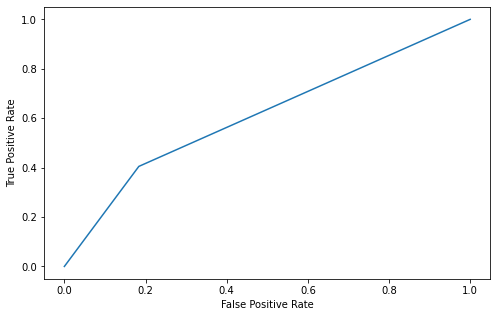


A acuracia média com dez dobras é de 72.39 % com erro padrão de  0.75 % 


A precisão média com dez dobras é de 38.5 % com erro padrão de  1.5 % 


A sensibilidade média com dez dobras é de 41.53 % com erro padrão de  1.83 % 



In [14]:
arvore = tree.DecisionTreeClassifier()

prototipo(arvore,X_train,y_train,X_test,y_test)

# Árvore Aleatória

[[6593  404]
 [1281  722]]
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      6997
           1       0.64      0.36      0.46      2003

    accuracy                           0.81      9000
   macro avg       0.74      0.65      0.67      9000
weighted avg       0.79      0.81      0.79      9000



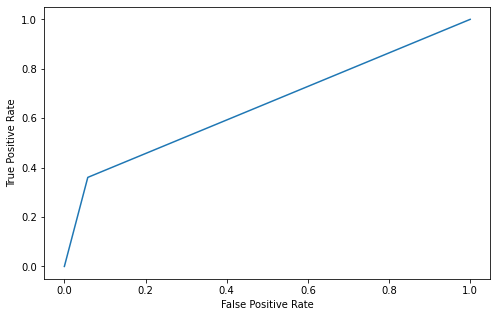


A acuracia média com dez dobras é de 81.73 % com erro padrão de  0.56 % 


A precisão média com dez dobras é de 65.17 % com erro padrão de  1.86 % 


A sensibilidade média com dez dobras é de 37.31 % com erro padrão de  2.16 % 



In [15]:
arvore_aleatoria = RandomForestClassifier()

prototipo(arvore_aleatoria,X_train,y_train,X_test,y_test)

# AdaBoost

[[6674  323]
 [1371  632]]
              precision    recall  f1-score   support

           0       0.83      0.95      0.89      6997
           1       0.66      0.32      0.43      2003

    accuracy                           0.81      9000
   macro avg       0.75      0.63      0.66      9000
weighted avg       0.79      0.81      0.78      9000



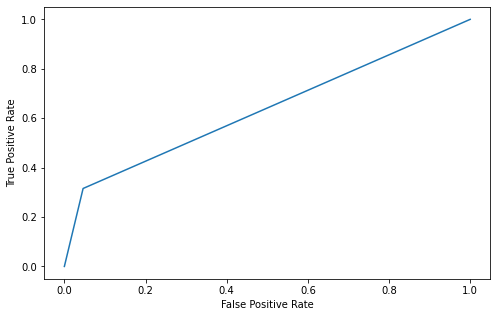


A acuracia média com dez dobras é de 81.84 % com erro padrão de  0.67 % 


A precisão média com dez dobras é de 68.28 % com erro padrão de  2.81 % 


A sensibilidade média com dez dobras é de 33.45 % com erro padrão de  2.14 % 



In [16]:
ada = AdaBoostClassifier(n_estimators=100)

prototipo(ada,X_train,y_train,X_test,y_test)

# Naive bayes

[[1673 5324]
 [ 224 1779]]
              precision    recall  f1-score   support

           0       0.88      0.24      0.38      6997
           1       0.25      0.89      0.39      2003

    accuracy                           0.38      9000
   macro avg       0.57      0.56      0.38      9000
weighted avg       0.74      0.38      0.38      9000



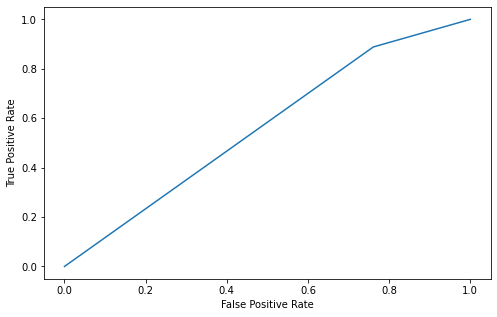


A acuracia média com dez dobras é de 37.71 % com erro padrão de  1.0 % 


A precisão média com dez dobras é de 24.71 % com erro padrão de  0.34 % 


A sensibilidade média com dez dobras é de 88.73 % com erro padrão de  1.39 % 



In [242]:
naive = GaussianNB()

prototipo(naive,X_train,y_train,X_test,y_test)

# Análise discriminante quadrática

[[4869 2128]
 [ 652 1351]]
              precision    recall  f1-score   support

           0       0.88      0.70      0.78      6997
           1       0.39      0.67      0.49      2003

    accuracy                           0.69      9000
   macro avg       0.64      0.69      0.64      9000
weighted avg       0.77      0.69      0.71      9000



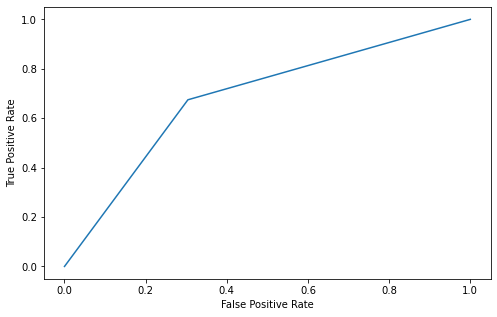


A acuracia média com dez dobras é de 67.58 % com erro padrão de  1.95 % 


A precisão média com dez dobras é de 37.5 % com erro padrão de  1.61 % 


A sensibilidade média com dez dobras é de 69.17 % com erro padrão de  2.73 % 



In [243]:
QDA=QuadraticDiscriminantAnalysis()

prototipo(QDA,X_train,y_train,X_test,y_test)

# Deep Learning

Está aqui mais para demonstrar como seria a aplicação com as ferramentas já utilizadas no relatório, o scikit learn não possui uma biblioteca muito aprofundada para aplicação deste algorimto, faltam ferramentas para modificar camadas e a implementação não permite modelos muito complexos, além de não possuir nenhuma aceleração por GPU, tornando o treinamento do modelo muito mais lento comparado a implementações utilizando o keras ou o pytorch.

[[6652  345]
 [1663  340]]
              precision    recall  f1-score   support

           0       0.80      0.95      0.87      6997
           1       0.50      0.17      0.25      2003

    accuracy                           0.78      9000
   macro avg       0.65      0.56      0.56      9000
weighted avg       0.73      0.78      0.73      9000



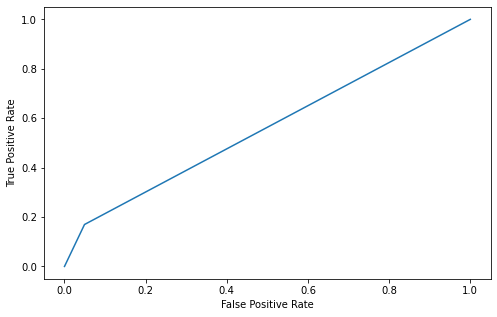


A acuracia média com dez dobras é de 73.46 % com erro padrão de  8.99 % 


A precisão média com dez dobras é de 47.2 % com erro padrão de  11.75 % 


A sensibilidade média com dez dobras é de 31.72 % com erro padrão de  19.77 % 



In [244]:
dl = MLPClassifier()

prototipo(dl,X_train,y_train,X_test,y_test)

# Graficos de comparação de modelos

## Precisão

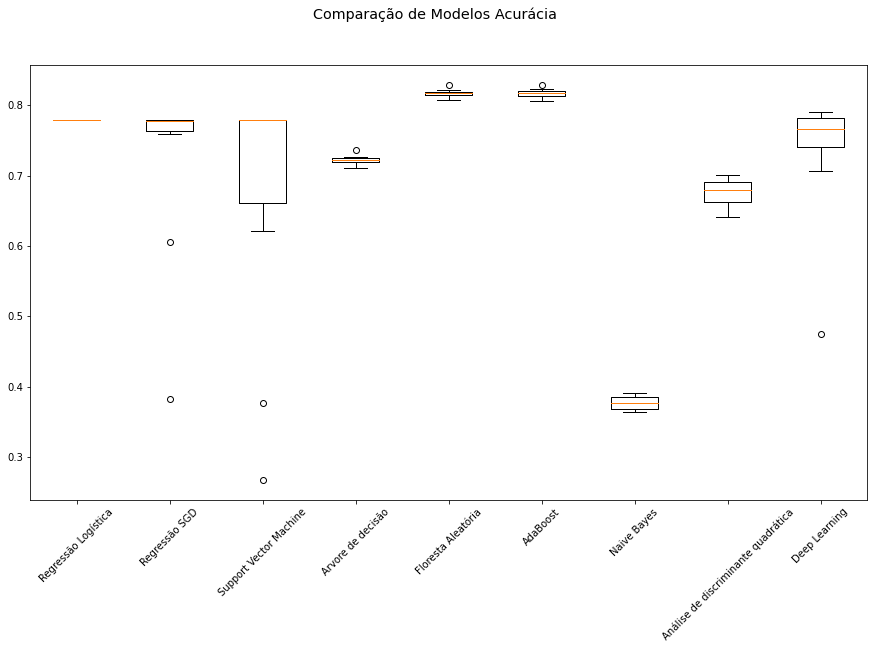

In [249]:
modelos = ['Regressão Logística','Regressão SGD', 'Support Vector Machine','Arvore de decisão', 'Floresta Aleatória','AdaBoost','Naive Bayes','Análise de discriminante quadrática', 'Deep Learning']

acuracias = list(map(lambda x: x['test_accuracy'],resultados ))

plt.rcParams["figure.figsize"] = (15,8)
plt.rcParams["figure.titlesize"] = 'x-large'

fig = plt.figure()
fig.suptitle('Comparação de Modelos Acurácia')
ax = fig.add_subplot(111)
plt.boxplot(acuracias)
ax.set_xticklabels(modelos,rotation = 45)
plt.show()

## Sensibilidade

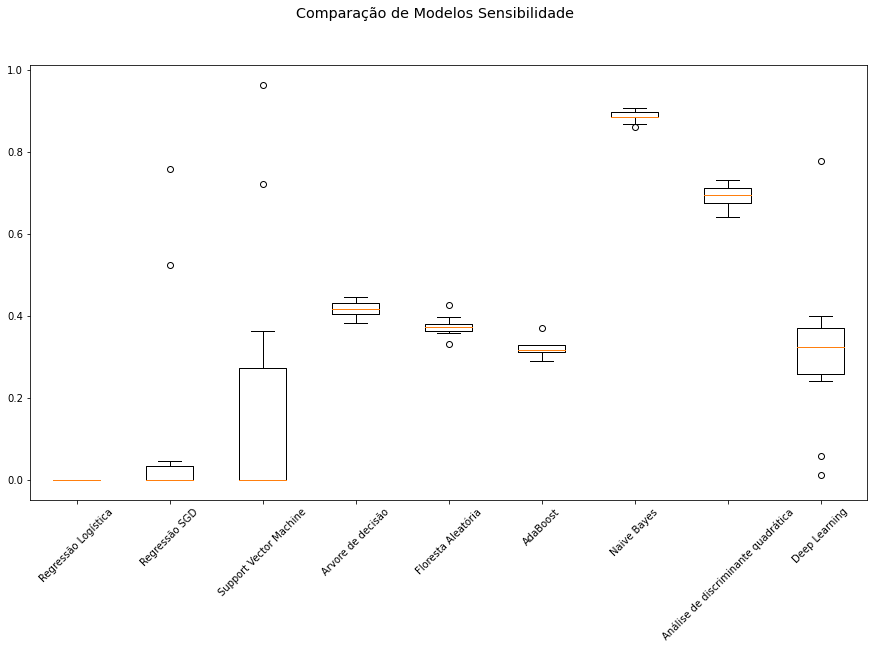

In [246]:
sensibilidades = list(map(lambda x: x['test_recall'],resultados ))

fig = plt.figure()
fig.suptitle('Comparação de Modelos Sensibilidade')
ax = fig.add_subplot(111)
plt.boxplot(sensibilidades )
ax.set_xticklabels(modelos,rotation = 45)
plt.show()

## Precisão

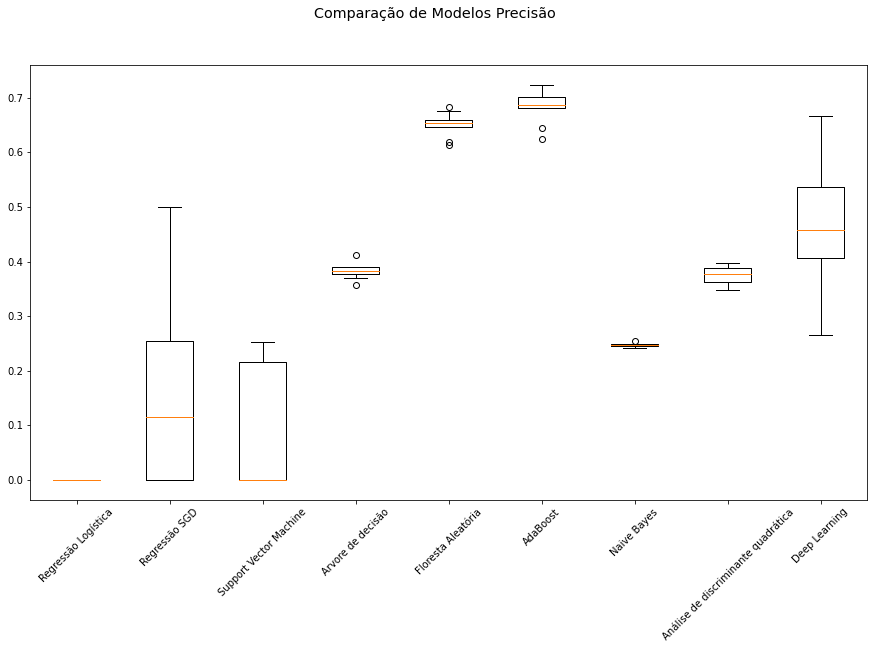

In [247]:
precisoes = list(map(lambda x: x['test_precision'],resultados ))

fig = plt.figure()
fig.suptitle('Comparação de Modelos Precisão')
ax = fig.add_subplot(111)
plt.boxplot(precisoes )
ax.set_xticklabels(modelos,rotation = 45)
plt.show()

# Conclusão
O modelo escolhido ponderando as metricas de performance a cima e o problema em questão é o de Análise de Discriminate Quadrática, dado que foi o modelo que apresentou melhor sensibilidade enquanto mantinha boa precisão e acurácia.